Dask Approach to Non-SQL PTM Queries
--

v01: move away from classes, try to organize the computation 
primarily in dask.
v02: target optimization.

In [1]:
import postproc_dask as post
import six

In [2]:
import matplotlib.pyplot as plt
import conc_figure
import six
import stompy.plot.cmap as scmap
from stompy.spatial import proj_utils
from matplotlib import cm
cmap=cm.CMRmap_r
cmap=scmap.cmap_clip(cmap,0.03,1.0)

%matplotlib notebook

In [3]:
import itertools

In [4]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import re

from stompy.grid import unstructured_grid
from stompy import utils, memoize
from stompy.model.fish_ptm import ptm_config, ptm_tools
from stompy.model.suntans import sun_driver
from scipy.stats import spearmanr

import stompy.plot.cmap as scmap
from scipy import stats
import seaborn as sns
turbo=scmap.load_gradient('turbo.cpt')

Overall Process
===

1. SUNTANS hydro runs
2. SUNTANS average output
3. ptm-formatted average output
4. PTM runs
5. Load data

The top-level query is something like *generate a map of concentrations for...*

filter on:
 - sources $x$
 - settling classes $y$
 - vertical positions $z$
 - horizontal positions $h$

weighted by

 - loading data 
 - age
 
mapped by one of ...

 - bounding box
 - put on hydro grid
 - put on regular grid

and possibly smoothed.

In [5]:
# Experiment level configuration -- small, all python native data.
import cfg_v01 
cfg=dict(cfg_v01.cfg)

In [6]:
# Load the grid into... grid
hydro_path=cfg['sun_paths'][0]
ptm_ds=xr.open_dataset(os.path.join(hydro_path,"ptm_average.nc_0000.nc"))
grid=unstructured_grid.UnstructuredGrid.read_ugrid(ptm_ds,dialect='fishptm')
ptm_ds.close()   

cfg['grid']=grid 

In [9]:
# So far this is only used locally.  Slow to compute (15s)
Msmooth=grid.smooth_matrix()
Msmooth_K=grid.smooth_matrix(K=100*np.ones(grid.Nedges()))

INFO:utils:56849/99089
INFO:utils:56193/99089


In [7]:
# Or could make this delayed and have it execute on each client?
cfg['load_data']=post.get_load_data()

In [8]:
# Hydro timestamps
cfg['hydro_timestamps']=post.load_hydro_timestamps(cfg['sun_paths'])

In [9]:
cfg['bc_ds_d']=post.bc_ds(cfg=cfg)

In [10]:
areas=grid.cells_area()    

In [11]:
# Set this a bit early, as it controls cache location which 
# is needed for some testing.
cfg['manta_out_dir']="manta_sets_20210925d"

# now the 021b runs.
# c suffix: use tighter -0.095 z filter.
# 20200227: start of v03
# 20200302: start of v04
# 20200305: try larger window -- extra 24 hours in both directions.
# 20200312: new sources in ptm data, with v02 stormwater concs.
# 20200330: more new sources.
# 20210210a: dask code, new hydro, new ptm. new year.
# 20210317a: new ptm runs with no SJ loss...
#            has the w_s bug
# 20210317b: fixed w_s bug
# 20210317c: switch to weathered loads
# 20210708c: including beaching and deposition counts.
# 20210726d: other stuff, and now prep to optimize just 3 parameters
os.makedirs(cfg['manta_out_dir'],exist_ok=True)

Next steps
--


1. Recreate some of the figures from before, including on-grid smoothing.  
  a. Sample plot: from the powerpoint. 2017-08-30 to 2017-09-14. Surface particles
     max age of 10 days.   *This plot is similarish -- not exactly the same but close
     enough to rule out fundamental errors*
2. Pull out manta samples as before. Maybe skip putting it on the grid, just
   query a radius.
  a. Implement in this notebook
  b. Move all of this to a module.

In [12]:
ll2utm=proj_utils.mapper('WGS84','EPSG:26910')
# Load the manta data, clean it up
manta_fn='manta_summary-v03.csv'
manta=pd.read_csv(manta_fn)
# manta.head()

In [13]:
godwin_offset_h=post.godwin_offset_h
godwin=post.godwin

In [14]:
import numexpr as ne
ne.set_num_threads(16) # reasonable on cws-linuxmodeling

8

In [ ]:
# Streamlined version that only allows 
# tau, shore_factor and bed_factor to change.
# Msmooth is already set.

# Precalculate:
if 1: 
    manta=manta.sort_values('DATE') # helps with locality during precalculation
    storm_factor=1.0
    step=-10000
    precalc={} # idx => stuff.

    # Force mantas to be sorted, so that data from the same day
    # is grouped together.
    last_DATE=None
    df=None

    for idx,rec in utils.progress(manta.iterrows()):
        #print(idx)
        # since we're just pulling out whole days, cache by day.
        # and pull through the end of that day
        # 5s, all in read_parquet
        if rec.DATE==last_DATE:
            pass
        else:
            df=post.particles_for_date(rec.DATE,cfg=cfg)
            last_DATE=rec.DATE

        # Trawl-specific processing:
        # Pull subset of cells
        # add a cell weighting, and a time weighting for the tidal filter
        cells,weights=post.rec_to_cell_weights(rec,areas=areas,grid=grid,
                                               Msmooth=Msmooth,smooth=step,thresh=1e-5)
        df_spatial=pd.DataFrame(dict(cell=cells,weight_spatial=weights)).set_index('cell')
        df_spatial_sort=df_spatial.sort_index()
        space_cell=df_spatial_sort.index.values
        space_weight=df_spatial_sort['weight_spatial'].values
        df_cell=df.cell.values
        df_idx=np.searchsorted(space_cell,df_cell).clip(0,len(space_cell)-1)
        sel=space_cell[df_idx]==df_cell
        tdf=df[sel].copy()
        weight_spatial=space_weight[df_idx[sel]]

        t_sample=np.datetime64(rec['DATE'])    
        t_center = t_sample+np.timedelta64(8,'h') + np.timedelta64(12,'h')
        delta_hours=((tdf['time']-t_center)/np.timedelta64(1,'h')).astype(np.int32)
        weight_time=godwin[delta_hours+godwin_offset_h]
        age=tdf['time'].values - tdf['rel_time'].values

        age_s=(age/np.timedelta64(1,'s')).astype(np.float32)
        bed_hits=tdf['bed_hits'].values
        shore_hits=tdf['shore_hits'].values
        mp_per_area = (tdf['mp_per_particle'] / areas[tdf['cell']]).values

        group_weight=post.group_weights(tdf,storm_factor)

        # Omits decay, bed, shore weights
        pre_weighted=weight_spatial*weight_time*group_weight*mp_per_area
        # Final code below then needs age_s, bed_hits, shore_hits
        sel=pre_weighted>0.0
        
        bundle=np.zeros(sel.sum(),[('preweighted',np.float32),
                                   ('age_s',np.float32),
                                   ('bed_hits',np.int16),
                                   ('shore_hits',np.int16)])
        bundle['preweighted']=pre_weighted[sel]
        bundle['age_s']=age_s[sel]
        bundle['bed_hits']=bed_hits[sel]
        bundle['shore_hits']=shore_hits[sel]
        
        print(f"Manta sample {idx}: {bundle.nbytes:.2e} bytes, {len(bundle):.2e} elements")
        
        # Can get maybe a factor of 3 by combining duplicates
        df_bundle=pd.DataFrame.from_records(bundle)
        uniquified=df_bundle.groupby(['age_s','bed_hits','shore_hits'])['preweighted'].sum().reset_index()
        bundle=np.zeros(len(uniquified),dtype=bundle.dtype)
        bundle['preweighted']=uniquified['preweighted']
        bundle['age_s']=uniquified['age_s']
        bundle['bed_hits']=uniquified['bed_hits']
        bundle['shore_hits']=uniquified['shore_hits']
        print(f"    uniquified: {bundle.nbytes:.2e} bytes, {len(bundle):.2e} elements")
        
        precalc[idx]=bundle

#                        weights=ne.evaluate('weight_spatial*weight_time*decay*group_weight*bed_weight*shore_weight')
#                        unweighted=mp_per_area
#                        final_weights=weights
#                        # final_concs=weights*mp_per_area
#                        C=ne.evaluate( 'sum(weights*mp_per_area)')

In [60]:
%load_ext line_profiler

In [162]:
pred_type=np.float64

def predict_mantas_fast(tau_d,shore_factor=1e-2,bed_factor=1e-2):
    # tau_d: e-folding decay time scale in days
    # shore_factors: particle weight derated by (1-shore_factor)**hits
    # bed_factors: particle weighte derated by (1-bed_factor)**hits
    print(f"tau={tau_d}  shore={shore_factor}  bed={bed_factor}")
    preds=[]

    tau_s=tau_d*86400

    # So when age_s==tau_s, we get exp(-1) decrease
    # tau_s * log_decay_rate = -1
    # log_decay_rate=-1/tau_s
    log_decay_rate=pred_type(-1/tau_s)
    log_bed_rate=np.log(pred_type(1-bed_factor))
    log_shore_rate=np.log(pred_type(1-shore_factor))

    for idx,rec in utils.progress(manta.iterrows()):
        # print(idx)
        bundle=precalc[idx]
        age_s=bundle['age_s']
        shore_hits=bundle['shore_hits']
        bed_hits=bundle['bed_hits']
        preweighted=bundle['preweighted']
                                        
        pred=dict(idx=idx,storm_factor=storm_factor,tau_d=tau_d,
                  step=step,Msmooth_i=0,
                  shore_factor=shore_factor,bed_factor=bed_factor)
        pred['idx']=idx
    
        # All in one go was actually half as fast
        weight=ne.evaluate('''exp( age_s*log_decay_rate 
                                  + shore_hits*log_shore_rate 
                                  + bed_hits*log_bed_rate )''')
        C=ne.evaluate( 'sum(preweighted*weight)')
        # What if we want the derivative?
        # Could calculate derivatives, but remember have to do this for all samples,
        # then take the derivative of the cost function w.r.t  
        # dC_d_decay = ne.evaluate('1/exp(log_decay_rate) * sum(age_s*preweighted*weight)')
        # dC_d_shore = ne.evaluate('1/exp(log_shore_rate) * sum(shore_hits*preweighted*weight)')
        # dC_d_bed   = ne.evaluate('1/exp(log_bed_rate  ) * sum(bed_hits*preweighted*weight)')  
        
        pred['C_model']=C
        preds.append(pred)

    df_pred=pd.DataFrame(preds)
    df_pred['C_model']=df_pred['C_model'].astype(np.float64)
    manta_pred=df_pred.join(manta,on='idx')
    return manta_pred

In [163]:
%%time
# 6.7s
# 2.8s after combining all rates, which regresses to 5.5s if I do the
# summation in line, too.
# Those times with 8 threads. Down to 1.9s with 16 threads.
# Back to 2.49 if 64 bit. 
#%lprun -f predict_mantas_fast 
result=predict_mantas_fast(tau_d=60,shore_factor=0.01,bed_factor=0.01)
#metrics(result)

tau=60  shore=0.01  bed=0.01
CPU times: user 14.7 s, sys: 3.21 s, total: 17.9 s
Wall time: 2.49 s


In [119]:
def predict_mantas_fast_multi(tau_ds,shore_factors,bed_factors):
    dfs=[]
    for tau_d,shore_factor,bed_factor in itertools.product(tau_ds,shore_factors,bed_factors):
        #print(f"tau={tau/np.timedelta64(86400,'s')}d shore_factor={shore_factor}  bed_factor={bed_factor}")
        dfs.append(predict_mantas_fast(tau_d,shore_factor=shore_factor,bed_factor=bed_factor))
    combined=pd.concat(dfs)
    return combined
            

In [117]:
def metrics(grp):
    obs=grp['part_per_m2_nofiber'].values
    mod=grp['C_model'].values
    
    skill={}
    skill['rho'],skill['rho_p']=spearmanr(obs, mod)
    skill['norm_std']=mod.std() / obs.std()
    skill['norm_mag']=mod.mean() / obs.mean()
    skill['rel_std_obs']=obs.std() / obs.mean()
    skill['rel_std_mod']=mod.std() / mod.mean()
    
    # log-transformed
    min_nonzero=obs[obs>0].min()
    r_log=np.corrcoef(np.log(obs.clip(min_nonzero)),
                      np.log(mod.clip(min_nonzero)))[0,1]
    skill['r_log']=r_log
    
    # Same but drop top/bottom 2 outliers:
    obs_rank=np.argsort(np.argsort(obs))
    sel=(obs_rank>2)&(obs_rank<len(obs)-2)
    r=np.corrcoef(obs[sel], mod[sel])[0,1]
    skill['r_sub']=r
    
    skill['norm_std_sub']=mod[sel].std() / obs[sel].std()
    skill['norm_mag_sub']=mod[sel].mean() / obs[sel].mean()
    skill['rel_std_obs_sub']=obs[sel].std() / obs[sel].mean()
    skill['rel_std_mod_sub']=mod[sel].std() / mod[sel].mean()

    return pd.Series(skill)
   

In [120]:
# Set of predictions just over tunable parameters:
tau_ds=[5,10,20,30,60]
# First go round suggested that 0.001 was too small an increment.
shore_factors=[0,0.02,0.05,0.1,0.2,0.4]
bed_factors=[0,0.02,0.05,0.1,0.2,0.4]

In [103]:
manta_pred_tune=predict_mantas_fast_multi(tau_ds=tau_ds,
                                          bed_factors=bed_factors,
                                          shore_factors=shore_factors)
manta_pred_tune.to_parquet('manta_pred_tune_v05.parquet')

tau=5.0d shore_factor=0  bed_factor=0
tau=5.0d shore_factor=0  bed_factor=0.02
tau=5.0d shore_factor=0  bed_factor=0.05
tau=5.0d shore_factor=0  bed_factor=0.1
tau=5.0d shore_factor=0  bed_factor=0.2
tau=5.0d shore_factor=0  bed_factor=0.4
tau=5.0d shore_factor=0.02  bed_factor=0
tau=5.0d shore_factor=0.02  bed_factor=0.02
tau=5.0d shore_factor=0.02  bed_factor=0.05
tau=5.0d shore_factor=0.02  bed_factor=0.1
tau=5.0d shore_factor=0.02  bed_factor=0.2
tau=5.0d shore_factor=0.02  bed_factor=0.4
tau=5.0d shore_factor=0.05  bed_factor=0
tau=5.0d shore_factor=0.05  bed_factor=0.02
tau=5.0d shore_factor=0.05  bed_factor=0.05
tau=5.0d shore_factor=0.05  bed_factor=0.1
tau=5.0d shore_factor=0.05  bed_factor=0.2
tau=5.0d shore_factor=0.05  bed_factor=0.4
tau=5.0d shore_factor=0.1  bed_factor=0
tau=5.0d shore_factor=0.1  bed_factor=0.02
tau=5.0d shore_factor=0.1  bed_factor=0.05
tau=5.0d shore_factor=0.1  bed_factor=0.1
tau=5.0d shore_factor=0.1  bed_factor=0.2
tau=5.0d shore_factor=0.1  bed_fac

In [24]:
# manta_pred_master=pd.read_parquet('manta_pred_master_v03.parquet')

In [107]:
all_metrics=manta_pred_tune.groupby(['tau_d','shore_factor','bed_factor']).apply(metrics)

In [108]:
# Best overall rho:
#  tau=5, storm=1, grid smooth, step=-100000 => rho=0.74
#  insensitive to tau. mag still something like 14x too large for tau=60,
#  interestingly, even with tau=5, magnitude still 7x too large.
# Best overall r_log:
#  shore_factor is pinned to 0.1, bed_factor 0.00, tau all over the place.
all_metrics.sort_values('r_log',ascending=False).head(10)

rho         rho_p  norm_std  norm_mag  \
tau_d shore_factor bed_factor                                               
5.0   0.10         0.00        0.736670  2.658788e-12  0.606912  1.367755   
10.0  0.10         0.00        0.728453  6.091972e-12  0.697765  1.622280   
5.0   0.05         0.00        0.736626  2.670756e-12  1.370402  2.427387   
      0.20         0.00        0.736888  2.599713e-12  0.292370  0.718497   
20.0  0.10         0.00        0.732037  4.259145e-12  0.754339  1.809323   
5.0   0.10         0.02        0.735358  3.041109e-12  0.595051  1.312418   
10.0  0.05         0.00        0.736888  2.599713e-12  1.702180  3.007960   
30.0  0.10         0.00        0.733086  3.831419e-12  0.775685  1.890064   
60.0  0.10         0.00        0.733960  3.506652e-12  0.798870  1.987290   
5.0   0.20         0.02        0.738549  2.190016e-12  0.287514  0.695496   

                               rel_std_obs  rel_std_mod     r_log     r_sub  \
tau_d shore_factor bed_factor                                                 
5.0   0.10         0.00           4.739295     2.102961  0.706516  0.495592   
10.0  0.10         0.00           4.739295     2.038436  0.706286  0.507423   
5.0   0.05         0.00           4.739295     2.675610  0.706017  0.539059   
      0.20         0.00           4.739295     1.928507  0.705893  0.417216   
20.0  0.10         0.00           4.739295     1.975896  0.705805  0.514183   
5.0   0.10         0.02           4.739295     2.148797  0.705761  0.495909   
10.0  0.05         0.00           4.739295     2.681929  0.705699  0.542660   
30.0  0.10         0.00           4.739295     1.945013  0.705681  0.516748   
60.0  0.10         0.00           4.739295     1.905147  0.705501  0.519610   
5.0   0.20         0.02           4.739295     1.959195  0.705171  0.416457   

                               norm_std_sub  norm_mag_sub  rel_std_obs_sub  \
tau_d shore_factor bed_factor                                                
5.0   0.10         0.00            5.192087      3.602668         1.493503   
10.0  0.10         0.00            5.950538      4.252837         1.493503   
5.0   0.05         0.00           11.806338      6.500445         1.493503   
      0.20         0.00            2.479402      1.865297         1.493503   
20.0  0.10         0.00            6.416790      4.732487         1.493503   
5.0   0.10         0.02            5.092853      3.455353         1.493503   
10.0  0.05         0.00           14.659231      8.043649         1.493503   
30.0  0.10         0.00            6.590945      4.940352         1.493503   
60.0  0.10         0.00            6.778628      5.191421         1.493503   
5.0   0.20         0.02            2.439941      1.805276         1.493503   

                               rel_std_mod_sub  
tau_d shore_factor bed_factor                   
5.0   0.10         0.00               2.152405  
10.0  0.10         0.00               2.089699  
5.0   0.05         0.00               2.712554  
      0.20         0.00               1.985205  
20.0  0.10         0.00               2.025045  
5.0   0.10         0.02               2.201278  
10.0  0.05         0.00               2.721851  
30.0  0.10         0.00               1.992489  
60.0  0.10         0.00               1.950122  
5.0   0.20         0.02               2.018562

In [109]:
#df=predict_mantas_fast(np.timedelta64(5,'D'),0.10,0.0)
#m=metrics(df)

Optimization
==

Before something more sophisticated like stan or max likelihood, 
just optimize a cost function.

1. Maximize r_log.  This worked well, giving tau=90.47 shore=0.037 and bed=-0.0075. Even without any constraints, the values are not too crazy, and the result a bit better than before, $r_{log} = 0.7214559$. But I'm having trouble getting this result after changing the code to use 64-bit floats, so maybe that was a fluke.
2. Constrained optimization did not move much at all from the initial. This may be due to estimating gradients with a smaller epsilon than fmin, in fact slightly smaller than a 32-bit float can represent. The form is so simple that we might as well calculated gradients.
3. That said, unconstrained optimization with a penalty did not do any better. 
4. Including scale leads to tau=2e9 shore=0.426  bed=-0.005. Cost was based on log-transformed Murphy skill.

In [186]:
# Basic optimization: 
#  First, optimize r_log with no constraints: great
#  Then add constraints: fails to find much of anything
#  Then with a cost function including scale.
def cost_r_log(params):
    tau_d,shore_factor,bed_factor=params
    df=predict_mantas_fast(tau_d,shore_factor=shore_factor,bed_factor=bed_factor)
    m=metrics(df)
    print(f"   r_log={m.r_log} ")
    return 1.0 - m.r_log

In [187]:
from scipy.optimize import fmin

init=[90,0.04,0.01]
res=fmin(cost_r_log,init,full_output=True)
best,fopt,n_iter,n_func,warnflag = res
print(best)
best_r=1-cost_r_log(best)
print("r: ",best_r)
# [ 9.04679466e+01  3.71315029e-02 -7.50962958e-03]
# r_log = 0.7214559

tau=90.0  shore=0.04  bed=0.01
   r_log=0.6994299523732368 
tau=94.5  shore=0.04  bed=0.01
   r_log=0.6993732259392561 
tau=90.0  shore=0.042  bed=0.01
   r_log=0.6996341103984317 
tau=90.0  shore=0.04  bed=0.0105
   r_log=0.6992931925791644 
tau=93.0  shore=0.041333333333333326  bed=0.0095
   r_log=0.6996701998319051 
tau=94.5  shore=0.041999999999999996  bed=0.008999999999999998
   r_log=0.6998627211216706 
tau=88.5  shore=0.042666666666666665  bed=0.00933333333333333
   r_log=0.6999034663140902 
tau=85.5  shore=0.044  bed=0.008999999999999998
   r_log=0.7001598683604535 
tau=90.0  shore=0.04533333333333333  bed=0.008666666666666665
   r_log=0.7003145193313987 
tau=90.0  shore=0.048  bed=0.007999999999999997
   r_log=0.7007244874006033 
tau=90.0  shore=0.04733333333333333  bed=0.007333333333333329
   r_log=0.7008798050554489 
tau=90.0  shore=0.05  bed=0.005999999999999995
   r_log=0.7015119942781336 
tau=82.5  shore=0.05266666666666668  bed=0.006333333333333328
   r_log=0.70164852886

   r_log=0.7207488082313736 
tau=32.086537179240004  shore=0.04175337004060076  bed=-0.008469418116271001
   r_log=0.720996886432687 
tau=29.148472049654195  shore=0.03785617999611311  bed=-0.00871050585937406
   r_log=0.7208433303164015 
tau=34.72998601906049  shore=0.044368604347910054  bed=-0.008249817376108588
   r_log=0.7210025863526133 
tau=37.42427698787775  shore=0.04998648581969002  bed=-0.008213927647312887
   r_log=0.720898542468484 
tau=32.516673634475154  shore=0.04129130074801497  bed=-0.00839520186684737
   r_log=0.7210179949828924 
tau=30.58103016332288  shore=0.038495070497141334  bed=-0.008457862350856599
   r_log=0.7209574452571788 
tau=34.37608333472639  shore=0.04445910231969222  bed=-0.00832828750418518
   r_log=0.7210138674362022 
tau=35.66195814626801  shore=0.04499263490314408  bed=-0.008179453048489759
   r_log=0.7209863127204544 
tau=32.980392420997006  shore=0.04256318625623659  bed=-0.00839692684932569
   r_log=0.7210153330074324 
tau=31.85211357440521  sho

   r_log=0.7213245779927607 
tau=53.02536702634744  shore=0.03675520610407476  bed=-0.007879332780268002
   r_log=0.721375978276296 
tau=56.95391304380854  shore=0.03675347331674783  bed=-0.007852542316603026
   r_log=0.7213898722054605 
tau=61.02114214061369  shore=0.034567032937011424  bed=-0.007652712196312719
   r_log=0.7213428473443794 
tau=63.994097073390506  shore=0.03746001189182549  bed=-0.007617691445242896
   r_log=0.7213839996117724 
tau=68.78309327190563  shore=0.03525174853277979  bed=-0.0076378049053241834
   r_log=0.7214010634576393 
tau=76.90980245787367  shore=0.03424332435036467  bed=-0.007567961157928821
   r_log=0.7213826957515074 
tau=65.46626011878942  shore=0.03840978955722399  bed=-0.007752646915134017
   r_log=0.7214167453634767 
tau=67.6888191078773  shore=0.040331167867330264  bed=-0.007802614274544668
   r_log=0.7213656288479359 
tau=63.474747216278544  shore=0.03614999571267559  bed=-0.007877637979464589
   r_log=0.7213295579192232 
tau=63.864259609112516 

   r_log=0.7214345899237292 
tau=80.33923703508455  shore=0.037816608387878356  bed=-0.007576439713809427
   r_log=0.7214345884662366 
tau=80.30189480852411  shore=0.03780835978703792  bed=-0.007575961452298285
   r_log=0.7214345900160456 
tau=80.34024344255769  shore=0.037801245265767495  bed=-0.00757562135696908
   r_log=0.7214345898033276 
tau=80.25972581278177  shore=0.037795583617231995  bed=-0.007575876850117743
   r_log=0.7214345886485598 
tau=80.33545755278956  shore=0.03780898479894057  bed=-0.007575901214048381
   r_log=0.7214345900213643 
tau=80.27699324317084  shore=0.037812949899756663  bed=-0.007576351399893455
   r_log=0.7214345898809599 
tau=80.29280579301755  shore=0.03781002374125937  bed=-0.007576168889162361
   r_log=0.7214345900085397 
tau=80.3316027689417  shore=0.03781429738918417  bed=-0.007575924568058879
   r_log=0.7214345899268807 
tau=80.32082774352607  shore=0.03781171008246506  bed=-0.007575967543280944
   r_log=0.7214345900181053 
tau=80.34598094354226  s

In [146]:
# Now with constraints
from scipy.optimize import Bounds, minimize, show_options

In [170]:
init=[5,0.10,0.01]

# with default epsilon, 
# method='trust-constr' did not find a good minimum
# SLSQP didn't go anywhere.
# trust-constr did not accept an eps argument.
# eps=1e-5 made two iterations and stopped. 
# Trying again with double precision. no help.
# Again with finite diff rel step. no change.
res = minimize(cost_r_log, init, method='SLSQP',
               options={'finite_diff_rel_step':[0.1,0.1,0.1],
                        'disp': True}, 
               bounds=Bounds([1,0,0],[200,1,1]))
best_con=res.x
print(best_con) # [5.05815503 0.29121811 0.24529109]
print(1-res.fun)
# Pretty bad.

tau=5.0  shore=0.1  bed=0.01
   r_log=0.7061969328433135 
tau=5.000000014901161  shore=0.1  bed=0.01
   r_log=0.7061969328433969 
tau=5.0  shore=0.1000000149011612  bed=0.01
   r_log=0.7061969328759505 
tau=5.0  shore=0.1  bed=0.010000014901161194
   r_log=0.7061969322750462 
tau=5.000005595386028  shore=0.10219023227691651  bed=0.0
   r_log=0.7065656469661614 
tau=5.0000056102871895  shore=0.10219023227691651  bed=0.0
   r_log=0.7065656469676294 
tau=5.000005595386028  shore=0.1021902471780777  bed=0.0
   r_log=0.7065656469707579 
tau=5.000005595386028  shore=0.10219023227691651  bed=1.4901161193847656e-08
   r_log=0.7065656464351073 
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2934343530338386
            Iterations: 2
            Function evaluations: 8
            Gradient evaluations: 2
[5.0000056  0.10219023 0.        ]
0.7065656469661614


In [171]:
# Real options for constrained minimization failed, maybe
# because of small gradients?
lower=np.r_[1,0,0]
upper=np.r_[200,1,1]

def cost_r_log_bounded(x):
    base_cost=cost_r_log(x)
    low_err=(lower-x).clip(0)
    up_err =(x-upper).clip(0)
    d_bounds=upper-lower
    
    penalty=np.sum( (low_err+up_err)/d_bounds )
    return base_cost + penalty
    
init=[5,0.10,0.01]
res=fmin(cost_r_log_bounded,init,full_output=True)
best,fopt,n_iter,n_func,warnflag = res
print(best)
best_r=1-cost_r_log(best)

tau=5.0  shore=0.1  bed=0.01
   r_log=0.7061969328433135 
tau=5.25  shore=0.1  bed=0.01
   r_log=0.7061929495521431 
tau=5.0  shore=0.10500000000000001  bed=0.01
   r_log=0.706204405426735 
tau=5.0  shore=0.1  bed=0.0105
   r_log=0.7061778255756475 
tau=5.166666666666666  shore=0.10333333333333336  bed=0.0095
   r_log=0.706219456421001 
tau=5.25  shore=0.10500000000000004  bed=0.008999999999999998
   r_log=0.7062371417010453 
tau=4.916666666666666  shore=0.10666666666666669  bed=0.00933333333333333
   r_log=0.7062300430249177 
tau=5.111111111111111  shore=0.11111111111111116  bed=0.008888888888888885
   r_log=0.7062432998572467 
tau=5.166666666666666  shore=0.11666666666666675  bed=0.008333333333333328
   r_log=0.7062522261896509 
tau=5.222222222222221  shore=0.11388888888888898  bed=0.007777777777777771
   r_log=0.7062766443681319 
tau=5.333333333333332  shore=0.11833333333333346  bed=0.0066666666666666576
   r_log=0.706301015204412 
tau=5.583333333333332  shore=0.12000000000000013  b

   r_log=0.70658893717156 
tau=6.523605432979691  shore=0.09604901801459981  bed=1.993998090108967e-05
   r_log=0.706589326744622 
tau=6.542982083465045  shore=0.09505353732808602  bed=1.951534434106466e-05
   r_log=0.7065890448015667 
tau=6.52506851010491  shore=0.09584161559255969  bed=1.1425450065958209e-05
   r_log=0.7065898931467437 
tau=6.510822684029975  shore=0.0958902495186929  bed=7.610560506019409e-06
   r_log=0.7065906580254495 
tau=6.500251308221676  shore=0.09505214691765898  bed=2.511156352991246e-05
   r_log=0.7065903994641123 
tau=6.480137533355849  shore=0.09627407230588175  bed=1.5592725616949694e-05
   r_log=0.7065911559860621 
tau=6.448715258301252  shore=0.09688433979477962  bed=1.3631416254892214e-05
   r_log=0.7065920097123997 
tau=6.449587400722244  shore=0.09583547280615454  bed=1.096237929279305e-05
   r_log=0.7065928234299169 
tau=6.41257838459352  shore=0.09572870020193192  bed=6.47357848864474e-06
   r_log=0.7065944370996977 
tau=6.414492909728155  shore=0

   r_log=0.7066041132214196 
tau=5.889487221685821  shore=0.09690498160246996  bed=1.6313484603323774e-07
   r_log=0.7066041300575224 
tau=5.886872366786143  shore=0.09706584109388827  bed=-1.6538222594897965e-07
   r_log=0.7066041328344921 
tau=5.903985991587412  shore=0.09649570554473977  bed=1.7851840046767982e-07
   r_log=0.7066041277751854 
tau=5.910556152600117  shore=0.09684368800953334  bed=-6.158195718411664e-08
   r_log=0.7066041267560176 
tau=5.8936448667015515  shore=0.0966339236879809  bed=3.9286153167563814e-07
   r_log=0.7066041246693129 
tau=5.887039380586534  shore=0.09664555898517505  bed=1.0718865911812843e-07
   r_log=0.7066041368935342 
tau=5.878372734514809  shore=0.09661291435861985  bed=-3.046094115592844e-08
   r_log=0.7066041340819755 
tau=5.89336352920496  shore=0.09673024040027561  bed=-9.363359459627412e-08
   r_log=0.7066041486926272 
tau=5.893574532327404  shore=0.09665800286605458  bed=2.712377501076601e-07
   r_log=0.7066041309400268 
tau=5.876081431479

In [196]:
# Try cost function that includes scale and correlation
def cost_r_log_murphy(params):
    tau_d,shore_factor,bed_factor=params
    df=predict_mantas_fast(tau_d,shore_factor=shore_factor,bed_factor=bed_factor)
    obs=df['part_per_m2_nofiber'].values
    mod=df['C_model'].values
    murph=utils.murphy_skill(xmodel=np.log(mod),xobs=np.log(obs))
    
    return 1.0 - murph

In [197]:
init=[5,0.10,0.01]
res=fmin(cost_r_log_murphy,init,full_output=True)
best,fopt,n_iter,n_func,warnflag = res
print(best)
best_murph=1-cost_r_log_murphy(best)
best_murph

tau=5.0  shore=0.1  bed=0.01


<ipython-input-196-23a120529b0b>:7: RuntimeWarning: divide by zero encountered in log
  murph=utils.murphy_skill(xmodel=np.log(mod),xobs=np.log(obs))


tau=5.25  shore=0.1  bed=0.01
tau=5.0  shore=0.10500000000000001  bed=0.01
tau=5.0  shore=0.1  bed=0.0105
tau=5.166666666666666  shore=0.10333333333333336  bed=0.010333333333333332
tau=5.277777777777777  shore=0.10555555555555557  bed=0.00972222222222222
tau=5.416666666666664  shore=0.10833333333333334  bed=0.009333333333333329
tau=5.1388888888888875  shore=0.11111111111111113  bed=0.009777777777777772
tau=5.083333333333332  shore=0.1166666666666667  bed=0.00966666666666666
tau=5.166666666666664  shore=0.1166666666666667  bed=0.008999999999999996
tau=5.166666666666664  shore=0.12333333333333335  bed=0.008333333333333328
tau=5.444444444444441  shore=0.12722222222222224  bed=0.008222222222222212
tau=5.666666666666661  shore=0.13833333333333336  bed=0.00733333333333332
tau=5.194444444444441  shore=0.14388888888888896  bed=0.0075555555555555445
tau=5.601851851851844  shore=0.15370370370370373  bed=0.005814814814814802
tau=5.8611111111111  shore=0.17222222222222228  bed=0.003888888888888872

tau=164.5133814581245  shore=0.3426643876132687  bed=0.04052338294249354
tau=172.7021143085462  shore=0.33731046800705067  bed=0.043013503971143494
tau=184.869698775316  shore=0.33347875861022835  bed=0.04685422725231295
tau=154.17348266516353  shore=0.3391056494733782  bed=0.03669804976660104
tau=146.65112803051932  shore=0.3382427690083467  bed=0.03395012037166875
tau=179.720636155137  shore=0.3394562692008889  bed=0.0453555738825291
tau=155.83417113834864  shore=0.3398121179464043  bed=0.03743968139885448
tau=157.2931306165811  shore=0.33482110267128673  bed=0.03757744048190581
tau=162.70831874773864  shore=0.3407035663777732  bed=0.03978689732734661
tau=142.4418673922877  shore=0.34243708785798643  bed=0.03293624835739126
tau=165.13705257948158  shore=0.3385921229697846  bed=0.04049419006770544
tau=165.5117315232405  shore=0.3391221079342197  bed=0.040546410042247585
tau=170.35051171568642  shore=0.33877710292812746  bed=0.04209977436394413
tau=156.45863604461357  shore=0.340695426

tau=235.42915621551106  shore=0.3741371372389025  bed=-0.004101825250002543
tau=273.4885583035817  shore=0.3769134601320814  bed=-0.004156196807798277
tau=239.9636253261906  shore=0.3762993530206572  bed=-0.0049098293816668
tau=296.2108995484181  shore=0.37898360126934416  bed=-0.004900588185391049
tau=352.51952060046324  shore=0.3828351809378989  bed=-0.0052940863854402664
tau=333.52073692611367  shore=0.38261435796509236  bed=-0.00485583248334367
tau=397.1537794594973  shore=0.38782991112282383  bed=-0.005056126841735297
tau=404.60519954814083  shore=0.3861852953288424  bed=-0.004498778508282949
tau=486.925986659116  shore=0.39112826648293497  bed=-0.004293253071591023
tau=513.3718854744392  shore=0.39504772578465397  bed=-0.005343781924679969
tau=635.4235348469501  shore=0.40368700099093113  bed=-0.004894853039946478
tau=805.0298524962162  shore=0.41603870085172456  bed=-0.004891985467224191
tau=806.3980369603504  shore=0.41364655095671854  bed=-0.0046298868005948245
tau=885.5306986

tau=15188.657430358842  shore=0.42892466607235447  bed=-0.005095391899885416
tau=16536.92716087197  shore=0.4264442025531206  bed=-0.005169114013685744
tau=19089.88302424703  shore=0.42586306733789525  bed=-0.005216553937500307
tau=13678.131651643722  shore=0.4234723671181815  bed=-0.005197104355723833
tau=14811.025985680062  shore=0.4275615913338112  bed=-0.0051208200138450205
tau=17743.89581478991  shore=0.4250817028174433  bed=-0.005087746747518759
tau=20316.770544885054  shore=0.4239156368474748  bed=-0.005046031266081989
tau=18562.789200029034  shore=0.42798748532761344  bed=-0.005153334524030523
tau=20418.04879811388  shore=0.42544733579830696  bed=-0.0051526435096449965
tau=23221.560204330788  shore=0.4243902080305548  bed=-0.005168555257544984
tau=21279.562047749914  shore=0.4259001467424551  bed=-0.005093369173777108
tau=23650.87949118889  shore=0.42562811883712237  bed=-0.0050554967538227885
tau=21064.881907073435  shore=0.4229653049111902  bed=-0.005069171763263386
tau=19188

tau=1831828.6610511846  shore=0.4264264583005285  bed=-0.005104456804284922
tau=1488152.6665971272  shore=0.4267316888119822  bed=-0.005117377841386441
tau=1851073.6550266878  shore=0.4263618062399296  bed=-0.005111796732919295
tau=2237747.591734263  shore=0.42622593879344195  bed=-0.005114277158568398
tau=2374152.161140973  shore=0.4266784282882191  bed=-0.005116306642921231
tau=2549883.6515487703  shore=0.426246106407136  bed=-0.005104328945363858
tau=3080749.1440245914  shore=0.4260033152047129  bed=-0.005097804497352566
tau=2684910.9840931026  shore=0.42643110232299475  bed=-0.005117164743184667
tau=2349760.032638067  shore=0.4260142483584878  bed=-0.005105886971390649
tau=2368054.1290152464  shore=0.4265123833057863  bed=-0.005113701725038586
tau=3217492.1880780584  shore=0.4264312551173485  bed=-0.00511166687613878
tau=3900701.4546037437  shore=0.4264659795560579  bed=-0.005111601947748522
tau=3194181.8393520713  shore=0.42638521052299205  bed=-0.005102590335582644
tau=4061790.50

tau=271981906.5615677  shore=0.42640427788710733  bed=-0.005109380309831529
tau=259664243.93093652  shore=0.4263876618479435  bed=-0.005108925420007338
tau=283960530.0169952  shore=0.42638443898035416  bed=-0.005108910335001056
tau=278109621.09784293  shore=0.42639107444056035  bed=-0.005109296350022026
tau=310417469.53676534  shore=0.42639435581356167  bed=-0.005109249784634114
tau=350948637.9886725  shore=0.42639784546819737  bed=-0.005109386958329328
tau=361090440.59593725  shore=0.4263851542035446  bed=-0.0051092646144413195
tau=417841284.8240376  shore=0.42637918877738534  bed=-0.005109331347765169
tau=385890117.9698937  shore=0.42638721799417045  bed=-0.005109078255159109
tau=439780366.4059191  shore=0.42638528977097545  bed=-0.005108969207727649
tau=483919099.97669065  shore=0.42639442064812416  bed=-0.0051095035186644756
tau=505577966.66369224  shore=0.4263787309468988  bed=-0.0051091046022263015
tau=591761181.4349307  shore=0.4263871400404543  bed=-0.0051091202713042985
tau=70

0.386655742476365

In [191]:
len(df)

65

In [178]:
# Just discretize and plot decay/shore costs
taus=3**np.linspace(1,3.8,12)
shores=np.logspace(-2,-0.3,12)

recs=[]
for tau, shore in itertools.product(taus,shores):
    rec=dict(tau=tau,shore=shore)
    rec['r_log']=1-cost_r_log([tau,shore,0.0])
    recs.append(rec)

df_scan=pd.DataFrame(recs)

tau=3.0  shore=0.01  bed=0.0
   r_log=0.7039663415841882 
tau=3.0  shore=0.014273992181725854  bed=0.0
   r_log=0.7042016094823528 
tau=3.0  shore=0.02037468528039708  bed=0.0
   r_log=0.7044426240358694 
tau=3.0  shore=0.029082809839751277  bed=0.0
   r_log=0.7046866005601904 
tau=3.0  shore=0.04151278002752295  bed=0.0
   r_log=0.7049469553794124 
tau=3.0  shore=0.05925530975545678  bed=0.0
   r_log=0.7052412842798303 
tau=3.0  shore=0.08458098281751338  bed=0.0
   r_log=0.7055642261090244 
tau=3.0  shore=0.12073082874598748  bed=0.0
   r_log=0.7058662970818066 
tau=3.0  shore=0.17233109056135082  bed=0.0
   r_log=0.7060064210345872 
tau=3.0  shore=0.24598526393410117  bed=0.0
   r_log=0.7055452650784964 
tau=3.0  shore=0.3511191734215131  bed=0.0
   r_log=0.7032557757588078 
tau=3.0  shore=0.5011872336272722  bed=0.0
   r_log=0.6958599754724132 
tau=3.967987554918154  shore=0.01  bed=0.0
   r_log=0.7038754147844627 
tau=3.967987554918154  shore=0.014273992181725854  bed=0.0
   r_log

   r_log=0.7004733611376712 
tau=28.100472854884483  shore=0.02037468528039708  bed=0.0
   r_log=0.7018608848054514 
tau=28.100472854884483  shore=0.029082809839751277  bed=0.0
   r_log=0.7032033118032834 
tau=28.100472854884483  shore=0.04151278002752295  bed=0.0
   r_log=0.7043821553467674 
tau=28.100472854884483  shore=0.05925530975545678  bed=0.0
   r_log=0.7052810645489345 
tau=28.100472854884483  shore=0.08458098281751338  bed=0.0
   r_log=0.705691984376613 
tau=28.100472854884483  shore=0.12073082874598748  bed=0.0
   r_log=0.7053219560522804 
tau=28.100472854884483  shore=0.17233109056135082  bed=0.0
   r_log=0.7039758218208645 
tau=28.100472854884483  shore=0.24598526393410117  bed=0.0
   r_log=0.7014884074622418 
tau=28.100472854884483  shore=0.3511191734215131  bed=0.0
   r_log=0.6969182581128102 
tau=28.100472854884483  shore=0.5011872336272722  bed=0.0
   r_log=0.6866228844588822 
tau=37.16744219183235  shore=0.01  bed=0.0
   r_log=0.6987504483912458 
tau=37.16744219183235

In [182]:
1-cost_r_log([90,0.037,0])

tau=90  shore=0.037  bed=0
   r_log=0.7035069284742717 


0.7035069284742717

In [109]:
# Bed factor from 0 to 0.1 gives norm_mag of 10.4 down to 7.
# all_metrics.loc[('grid',-10000,60,1.0,slice(None),0.0),:]
# shore_factor is just scaling the whole set, not per particle.
all_metrics.loc[('grid',-10000,60,1.0,0.0,slice(None)),:]

rho  \
Msmooth_label step   tau_d storm_factor bed_factor shore_factor             
grid          -10000 60.0  1.0          0.0        0.00          0.721460   
                                                   0.02          0.723033   
                                                   0.05          0.732124   
                                                   0.10          0.733960   
                                                   0.20          0.734921   
                                                   0.40          0.722378   

                                                                        rho_p  \
Msmooth_label step   tau_d storm_factor bed_factor shore_factor                 
grid          -10000 60.0  1.0          0.0        0.00          1.205307e-11   
                                                   0.02          1.035632e-11   
                                                   0.05          4.221826e-12   
                                                   0.10          3.506652e-12   
                                                   0.20          3.179839e-12   
                                                   0.40          1.103354e-11   

                                                                  norm_std  \
Msmooth_label step   tau_d storm_factor bed_factor shore_factor              
grid          -10000 60.0  1.0          0.0        0.00          11.980150   
                                                   0.02           5.314557   
                                                   0.05           2.076582   
                                                   0.10           0.800525   
                                                   0.20           0.355251   
                                                   0.40           0.148471   

                                                                  norm_mag  \
Msmooth_label step   tau_d storm_factor bed_factor shore_factor              
grid          -10000 60.0  1.0          0.0        0.00          15.478660   
                                                   0.02           7.493209   
                                                   0.05           3.851411   
                                                   0.10           1.992696   
                                                   0.20           0.986435   
                                                   0.40           0.428863   

                                                                 rel_std_obs  \
Msmooth_label step   tau_d storm_factor bed_factor shore_factor                
grid          -10000 60.0  1.0          0.0        0.00             4.739295   
                                                   0.02             4.739295   
                                                   0.05             4.739295   
                                                   0.10             4.739295   
                                                   0.20             4.739295   
                                                   0.40             4.739295   

                                                                 rel_std_mod  \
Msmooth_label step   tau_d storm_factor bed_factor shore_factor                
grid          -10000 60.0  1.0          0.0        0.00             3.668113   
                                                   0.02             3.361344   
                                                   0.05             2.555307   
                                                   0.10             1.903915   
                                                   0.20             1.706790   
                                                   0.40             1.640726   

                                                                    r_log  \
Msmooth_label step   tau_d storm_factor bed_factor shore_factor             
grid          -10000 60.0  1.0          0.0        0.00          0.692087   
                                         

In [111]:
# Shore factor 0 to 0.1 gives norm_mag 10.4 down to 1.7
# And rho is slightly higher for 0.05.
# So that all makes sense.
all_metrics.loc[('grid',-10000,60,1.0,slice(None),0.0),:]

rho  \
Msmooth_label step   tau_d storm_factor bed_factor shore_factor             
grid          -10000 60.0  1.0          0.00       0.0           0.721460   
                                        0.02       0.0           0.709003   
                                        0.05       0.0           0.706774   
                                        0.10       0.0           0.695848   
                                        0.20       0.0           0.681425   
                                        0.40       0.0           0.660315   

                                                                        rho_p  \
Msmooth_label step   tau_d storm_factor bed_factor shore_factor                 
grid          -10000 60.0  1.0          0.00       0.0           1.205307e-11   
                                        0.02       0.0           3.867076e-11   
                                        0.05       0.0           4.733783e-11   
                                        0.10       0.0           1.242295e-10   
                                        0.20       0.0           4.166217e-10   
                                        0.40       0.0           2.174954e-09   

                                                                  norm_std  \
Msmooth_label step   tau_d storm_factor bed_factor shore_factor              
grid          -10000 60.0  1.0          0.00       0.0           11.980150   
                                        0.02       0.0           11.733857   
                                        0.05       0.0           11.437064   
                                        0.10       0.0           10.988861   
                                        0.20       0.0           10.170615   
                                        0.40       0.0            8.700317   

                                                                  norm_mag  \
Msmooth_label step   tau_d storm_factor bed_factor shore_factor              
grid          -10000 60.0  1.0          0.00       0.0           15.478660   
                                        0.02       0.0           13.935935   
                                        0.05       0.0           12.923872   
                                        0.10       0.0           11.780289   
                                        0.20       0.0           10.201592   
                                        0.40       0.0            8.097595   

                                                                 rel_std_obs  \
Msmooth_label step   tau_d storm_factor bed_factor shore_factor                
grid          -10000 60.0  1.0          0.00       0.0              4.739295   
                                        0.02       0.0              4.739295   
                                        0.05       0.0              4.739295   
                                        0.10       0.0              4.739295   
                                        0.20       0.0              4.739295   
                                        0.40       0.0              4.739295   

                                                                 rel_std_mod  \
Msmooth_label step   tau_d storm_factor bed_factor shore_factor                
grid          -10000 60.0  1.0          0.00       0.0              3.668113   
                                        0.02       0.0              3.990419   
                                        0.05       0.0              4.194070   
                                        0.10       0.0              4.420898   
                                        0.20       0.0              4.724905   
                                        0.40       0.0              5.092052   

                                                                    r_log  \
Msmooth_label step   tau_d storm_factor bed_factor shore_factor             
grid          -10000 60.0  1.0          0.00       0.0           0.692087   
                                        0

In [ ]:
# so an r_log of 0.717 is r2
all_metrics['r2_log']=all_metrics['r_log']**2
all_metrics.sort_values('r_log',ascending=False).head(10)

In [ ]:
# Best r_sub is also grid smoothed, step=-100000, but now
# tau=60.0. Again, not very sensitive to tau or storm_factor.
all_metrics.sort_values('r_sub',ascending=False).head(10)

In [ ]:
# Best magnitudes, including obs. outliers?
# This is all the place. Chooses some very noisy options,
# probably just happenstance to get close.  All pretty low rho
# and r_sub.
all_metrics['norm_mag_err']=np.abs(all_metrics['norm_mag']-1)
all_metrics.sort_values('norm_mag_err').head(10)

In [ ]:
# These mostly toss stormwater entirely.
# Again, poor rho and r_sub values.
all_metrics['norm_mag_sub_err']=np.abs(all_metrics['norm_mag_sub']-1)
all_metrics.sort_values('norm_mag_sub_err').head(10)

In [ ]:
fig=plt.figure(figsize=(6,2.5))
for smooth_type in ['grid','constant']:
    df_sub
    x=df_skill_smooth['smooth']

plt.plot(df_skill['tau_d'],df_skill['r'],label='Pearson $r$, full')
plt.plot(df_skill['tau_d'],df_skill['r_sub'],label='Pearson $r$, sub')

plt.plot(df_skill['tau_d'],df_skill['rho'],label=r'Spearman $\rho$, full')
plt.plot(df_skill['tau_d'],df_skill['rho_sub'],label=r'Spearman $\rho$, sub')

plt.plot(df_skill['tau_d'],df_skill['rlog'],label='Pearson $r$, full, log transform')
plt.plot(df_skill['tau_d'],df_skill['rlog_sub'],label='Pearson $r$, sub, log transform')
plt.legend(loc='upper left',bbox_to_anchor=[1.02,1.0],frameon=False)
plt.xlabel('Decay time scale (d)')
plt.axis(ymin=0,xmin=0)
fig.tight_layout()

Previously I got these results:
* Pearson $r$ is maximized by omitting any decay, as in $\tau\rightarrow\infty$
* Spearman $\rho$ is maximized by having a very short decay, 15h
* Log-transformed Pearson $r$ is maximized at around 25 days.

If I remove the top 2 and bottom 2 observed values, then Pearson
values come up to a level similar to log-pearson. Pearson
is still maximized by having little or no decay.

Re-running this, I don't see the local max in Pearson of the
log-transformed data.

What does it mean that Pearson correlation is highest at long decay
time scales, while Spearman is highest at short decay scales?

At short decay time scales, many of the predicted concentrations end up being
very small, substantially smaller than the observations even with no scaling
of the loads. This is penalized by Pearson, but for Spearman this correlates with
the lower concentration in the ocean compared to the estuary, and thus increases
skill.


In [ ]:
# What is Spearman just for getting two populations split correctly?
# Similar to what I get (for an offset that nearly makes the populations
# distinct)
# If the populations are different by a scale, then it takes a pretty 
# large scale (30?) to get a spearman of 0.7.

N=60
obs=np.random.random(N)
mod=np.random.random(N)

#off=0.8
#obs[:N//2]+=off
#mod[:N//2]+=off

fac=30
obs[:N//2]*=fac
mod[:N//2]*=fac

rho,p=spearmanr(obs,mod)
rho

In [ ]:
# Group samples - Central Bay, North Bay, South Bay, NMS.
def loc_to_region(s):
    if s.startswith('SPB') or s.startswith('SUB'): return 'NB'
    if s.startswith('SB') or s.startswith('LSB'): return 'SB'
    if s.startswith('GFNMS') or s.startswith('MBNMS') or s.startswith('CBNMS'): 
        return 'NMS'
    if s.startswith('CB') or s=='SFBay': return 'CB'
    raise Exception("No match for %s"%s)
    
def analyze_medians(df):
    dfm=df.loc[:,['region','obs','predicted']].melt(id_vars=['region']).set_index(['region','variable'])

    dfm.sort_index(inplace=True)

    def p_total(f):
        # Maximize the combined median test
        p_tot=1.0
        for region in ['CB','NB','SB','NMS']:
            obs=dfm.loc[ (region,'obs'), 'value']
            mod=f*dfm.loc[ (region,'predicted'), 'value']
            # is it better to choose just the modeled data where the observation
            # is valid?
            stat,p,M,cont=stats.median_test( obs[np.isfinite(obs)] ,
                                             mod[np.isfinite(mod)] )
            p_tot*=p
        return p_tot

    def cost(p):
        return -p_total( 10**p )

    from scipy.optimize import brute

    best=brute(cost,[[-4,1]],Ns=51)
    scale=10**best[0]
    p_tot=p_total(scale)
    print(f"P-total: {p_tot:.3f}  with scale: {1/scale:5f}")
    return p_tot,scale

In [ ]:
# Pulling in the old code from median comparisons.

manta_field='part_per_m2_nofiber'

for tau_d in [50]: # [0.5,1,1.5,2.,3,4,5,6,8,10,12,15,20,25,30,35,40,45,50,55,60]:
    print(f"Tau: {tau_d} days")
    tau=np.timedelta64(int(tau_d*86400),'s')
    df=predict_mantas(manta,tau,storm_factor=0.01)
    
    df=df[ df[manta_field].notnull() ].copy()
    
    regions=df['region']=df['SAMPLE LOCATION'].apply(loc_to_region)
    df=df.rename(columns={manta_field:'obs','C_model':'predicted'}).loc[:,['region','obs','predicted']]

    # Scale gets optimized to find the best nonparametric match
    p_tot,scale=analyze_medians(df)

    # This is not rigorous!
    obs_mag=1.0
    pred_mag=1/scale
    
    df['obs_frac']=df['obs'] / obs_mag
    df['pred_frac']=df['predicted'] / pred_mag

    dfm=df.loc[:,['region','obs_frac','pred_frac']].melt(id_vars=['region'])

    fig,ax=plt.subplots(1,1)# ,figsize=(10,3))
    sns.boxplot(x='region',y='value',hue='variable',data=dfm,fliersize=0,whis=0,
                ax=ax,bootstrap=1000)
    ax.axis(ymax=0.35,ymin=0)
    ax.legend(ax.artists,['Observed',f'Predicted/{pred_mag:.2f}'],loc='upper right')
    ax.set_ylabel('Particle m$^{-2}$')
    ax.set_xlabel('Region')
    
    ax.set_title(f'Tau={tau_d} days  $\\Pi \\rho$={p_tot:.2f}')
    df2=dfm.set_index(['region','variable'])
    p_tot=1.0
    for region in ['CB','NB','SB','NMS']:
        stat,p,M,cont=stats.median_test( df2.loc[ (region,'obs_frac'), 'value'] ,
                                         df2.loc[ (region,'pred_frac'), 'value'] )
        p_tot*=p
    print(f"{tau_d} days: ampl. error: {pred_mag/obs_mag:.3f} Median test net p: {p_tot:.5f}")
    
    print()
    fig.savefig(f'manta_comp_v05-tau{tau_d:.1f}.png',dpi=200)
    #break

In [ ]:
#plt.figure()
#plt.plot( df2.loc[('NB','obs_frac'),'value'], 'ro')
#plt.plot( df2.loc[('NB','pred_frac'),'value'],'go')

# Just 6 values...
display(df2.loc[('NB','obs_frac'),'value'])
display(df2.loc[('NB','pred_frac'),'value'])


In [ ]:
# For each manta sample, make a plot showing the conc. distribution at that time
# to debug what's up with the north bay samples:

tau_d=8
fac=39.81 # this is from analyze_medians.
six.moves.reload_module(conc_figure)

fig_dir=f"sample_wise_tau{tau_d}"
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

tau=np.timedelta64(int(tau_d*86400),'s')
for idx,rec in manta.iterrows():
    print(idx)
    img_fn=os.path.join(fig_dir,f"sample-{idx}.png")
    fig,axs=plt.subplots(1,2,figsize=(11,7))
    fig.subplots_adjust(left=0,right=1,top=1,bottom=0,wspace=0.02)
    df=particles_for_date(rec.DATE).copy()

    age=df['time'] - df['rel_time']
    decay=np.exp( -age/tau ) 
    
    # No spatial weighting, but need the godin filter weights
    t_sample=np.datetime64(rec.DATE)
    # Noon, local, day of sampling
    t_center = t_sample+np.timedelta64(8,'h') + np.timedelta64(12,'h')
    delta_hours=((df['time']-t_center)/np.timedelta64(1,'h')).astype(np.int32)
    weight_time=godwin[delta_hours+godwin_offset_h]

    df['count']=weight_time * decay * df['mp_per_particle'] 

    weight=weight_time * decay * df['mp_per_particle'] 
        
    ds_conc=post.particles_to_conc(df,grid,'count')

    ds_smooth=ds_conc.copy()
    for _ in range(30):
        ds_smooth['conc']=('cell',), Msmooth.dot(ds_smooth.conc.values)
    
    cell=grid.select_cells_nearest([rec.x,rec.y])
        
    zoom=conc_figure.BayConcFigure.zoom
    
    if ( (rec.x>zoom[0]) and
        (rec.x<zoom[1]) and
        (rec.y>zoom[2]) and
        (rec.y<zoom[3])):
        FigCls=conc_figure.BayConcFigure
        FigCls.cax_loc=[0.82,0.25,0.03,0.35] # normalized to axis 
    else:
        FigCls=conc_figure.CoastalConcFigure
        
    for ds,ax in zip([ds_smooth,ds_conc],axs):
        cf=FigCls(ds,fig=fig,ax=ax,grid=grid)
        cf.ax.plot([rec.x],[rec.y],'k+')
        conc_pred=ds.conc.isel(cell=cell).item()
        conc_pred=conc_pred / fac

        cf.ax.text(rec.x,rec.y,
                   f"part_per_m2_nofiber\n obs={rec.part_per_m2_nofiber:.2e}\npred={conc_pred:.2e}")

        cf.ax.text(0.01,0.95,f"Manta sample: {rec.SampleID}",transform=cf.ax.transAxes,va='top')
    fig.savefig(img_fn,dpi=200)


In [ ]:
ds_conc

Next Steps
-- 

2. Think through how to present the comparisons. *ish*
3. What can we infer from these patterns? *ish*
4. Results appear worse, in terms of likelihood, than 
   for the old runs, probably driven by NB. Looks like 
   I am underpredicting NB.  Sample by sample, not terribly
   obvious what's up.  It's just 6 samples.
4. Would having different loss coefficients for WW and SW be worth
   attempting?
    - This is worth trying, and try maximizing the pearson with outliers
      tossed.
    - Does not make much difference.
5. Is it worth following a similar analysis to previously, lumping
   samples into embayments? *Blindly running that same code, it suggests
   that decay times >=20 days are best, with little difference beyond there.*
   I'm getting smaller net prob. values, though, and it seems to be driven
   by NB being underpredicted (relatively speaking) in the new runs. Any chance
   I'm missing something in the north? The one map plot above looks okay, but compare
   for wet weather.
   
What about applying a much more aggressive smoothing, going implicit?

In [ ]:
six.moves.reload_module(conc_figure)

conc_figure.BayConcFigure(conc_ds,grid=grid,cmap=cmap)

Closer look at distributions
---

Tau constant at 25:

The predictions with the best spearman were grid smoothing -10000.
But the log-normal shape here is pretty terrible.

A moderately better log-normal comes up with no smoothing.

The best match in distribution is with no smoothing, tau=10,
storm_factor 0.05 or 0.01.

Given the amount of smoothing already taking place in time,
and how much the results here are affected by smoothing in
space, it may not be a great comparison.

In [ ]:
import seaborn as sns
import scipy.stats

fig,axs=plt.subplots(2,1)

mp=manta_pred_master
sel_tau=mp.tau==10
sel_smooth=mp.Msmooth_label=='constant'
sel_step=mp.step==0
sel_storm=mp.storm_factor==0.01
sel=sel_tau & sel_smooth & sel_step & sel_storm
df=manta_pred_master[sel]

nz=df['part_per_m2_nofiber']>0
kde=False
ret=sns.histplot(df['part_per_m2_nofiber'][nz],
                 log_scale=True,kde=kde,bins=25,ax=axs[0])
shape,loc,scale=stats.lognorm.fit(df['part_per_m2_nofiber'][nz],floc=0)
x=10**np.linspace(-5,2,300)
ln_pred=stats.lognorm.pdf(x,shape,loc=loc,scale=scale)
axs[0].plot(x,x*ln_pred*nz.sum()/2,color='tab:orange',label='Log-normal')

# ---- same, for model output
pred=df['C_model'].values
pred=pred[pred>0]

ret=sns.histplot(pred,log_scale=True,kde=kde,bins=25,ax=axs[1])
m_shape,m_loc,m_scale=stats.lognorm.fit(pred,floc=0)
ln_pred=stats.lognorm.pdf(x,m_shape,loc=m_loc,scale=m_scale)
axs[1].plot(x,x*ln_pred*nz.sum()/2,color='tab:orange',label='Log-normal')

print("Obs scale: ",scale)
print("Mod scale: ",m_scale)
print("Obs shape: ",shape)
print("Mod shape: ",m_shape)

In [ ]:
mp=manta_pred_master
sel_tau=mp.tau==60
sel_smooth=mp.Msmooth_label=='grid'
sel_step=mp.step==-100000
sel_storm=mp.storm_factor==1.0
sel=sel_tau & sel_smooth & sel_step & sel_storm
df=manta_pred_master[sel]

import statsmodels.formula.api as smf
from scipy.stats import spearmanr



In [ ]:
# statsmodels on log-transform
n_low=n_high=0
obs_rank=np.argsort(np.argsort(df['part_per_m2_nofiber']))
obs_sel=(obs_rank>=n_low) & (obs_rank<len(df)-n_high)
mod_rank=np.argsort(np.argsort(df['C_model']))
mod_sel=(mod_rank>=n_low) & (mod_rank<len(df)-n_high)

sel_nz=(df['part_per_m2_nofiber']>0)&(df['C_model']>0).values
sel=obs_sel&mod_sel&sel_nz
print(f"N={len(rank)}  Nsel={sel.sum()}")

data=df[sel].copy()
data['log_mod']=np.log(data['C_model'])
data['log_obs']=np.log(data['part_per_m2_nofiber'])

res=smf.ols(formula='log_mod ~ log_obs', data=data).fit()
res.summary()

In [ ]:
rho,rho_p=spearmanr(data['C_model'],data['part_per_m2_nofiber'])
print(f"Spearman:  rho={rho}  p-value={rho_p}")

# Testing speed of various basic operations

The current speed is way too slow for optimization.
Calculating results for one set of parameters is maybe
a couple of minutes.

Rewriting some math helps to some degree (e.g. 32-bit floats, 
combine the 3 exponentials into 1). But these are order 10-50%
speedups, not 10-100x speedup.

There aren't good speedups that I'm aware of for moving the sum inside
the exponential.

$$\sum_i mass_i \exp ( age_i\cdot rate_{age} + nbed_i\cdot rate_{bed} + nshore_i\cdot rate_{shore} )$$

I could move $mass_i$ into the exponential, turning a multiply into an add. 

This is very similar to "softmax", i.e. LogSumExp.  [This page](https://notebook.community/idjaw/logsumexp/Accelerating%20log-sum-exp)
shows that even using a custom SSE implementation only gets a 2X speedup.

In a test of one, 15M of 55M weights were zero.

A lookup table with 1600 values provides negligible speedup for a single
exponential term.

Culling small concentrations doesn't help enough. If we consider the largest
concentrations (before weights), then in one test it takes 16M/55M elements to 
accumulate 99% of the total concentration. So maybe it's a 4x speedup?

Any hope of GPU acceleration?
 * cws-linuxmodeling has a geforce GT 710
 * laptop has intel uhd 620

From specs, uhd 620 has theoretical max 384 GFLOPS single precision, and GT 710 has theoretical 366 GFLOPS. 
Aside from the non-boost clock, they have surprisingly similar specs. Tested performance with an opencl test program on the laptop, using floats and "native" operations. The calculation was to traverse the 50M data points 50 times, each time iterating over all elements and 10 times take 4 logs, some multiplies, sum, then an exp. This seems like a reasonable amount of calculation that is probably all sitting on the GPU. **The final speedup was about 4x.** 

In [159]:
N=10_000_000
ages=np.random.random(N).astype(np.float32)*60
shore_hits=np.random.randint(0,1600,N)
bed_hits=np.random.randint(0,1600,N)

mass=(np.random.random(N)*100).astype(np.float32)

tau=10 # days
rate_s=0.9
rate_b=0.99

In [151]:
# Division by a scalar is 2x slower than multiply by inverse of scalar
# Multiplying 3 arrays is 5x faster than exponentiation

In [166]:
%%time
# Baseline
# %time decay=np.exp(ages/tau) # 4.4ms
%time decay=np.exp(ages * np.float32(1./tau)) # 2.8ms
%time w_shore=np.exp(shore_hits*np.float32(np.log(rate_s)))
%time w_bed=np.exp(bed_hits*np.log(rate_b))
%time weight=decay*w_shore*w_bed

%time np.sum(mass*weight)
print()
# Whole thing is 360ms

CPU times: user 44.9 ms, sys: 0 ns, total: 44.9 ms
Wall time: 35 ms
CPU times: user 131 ms, sys: 25.8 ms, total: 157 ms
Wall time: 140 ms
CPU times: user 112 ms, sys: 45.9 ms, total: 157 ms
Wall time: 140 ms
CPU times: user 25.5 ms, sys: 0 ns, total: 25.5 ms
Wall time: 23.6 ms
CPU times: user 22.2 ms, sys: 0 ns, total: 22.2 ms
Wall time: 20.9 ms

CPU times: user 338 ms, sys: 71.9 ms, total: 410 ms
Wall time: 362 ms


In [172]:
%%time
# Group all decay weightings

log_weight=( ages * np.float32(1./tau) + 
             shore_hits*np.float32(np.log(rate_s)) +
             bed_hits*np.float32(np.log(rate_b)) )
%time weight=np.exp(log_weight)

%time np.sum(mass*weight)
print()
# Whole thing is 205ms
# Over half the time is in exp.

CPU times: user 117 ms, sys: 75.5 ms, total: 192 ms
Wall time: 167 ms
CPU times: user 25 ms, sys: 0 ns, total: 25 ms
Wall time: 22.8 ms

CPU times: user 168 ms, sys: 131 ms, total: 299 ms
Wall time: 255 ms


In [196]:
# Speed of exp vs. lookup table:
shore_lookup=(rate_s**np.arange(1600)).astype(np.float32)

%time w_shore=np.exp(shore_hits*np.float32(np.log(rate_s)))
%time w_shore2=shore_lookup[shore_hits] # Within 10% of same speed

np.allclose(w_shore,w_shore2) # True

CPU times: user 129 ms, sys: 128 ms, total: 257 ms
Wall time: 223 ms
CPU times: user 242 ms, sys: 2.1 ms, total: 244 ms
Wall time: 212 ms


True

In [213]:
%%prun -s cumulative
# 35s for a single sample, one set of parameters.
# Should be able to do this faster, maybe more like 1s?
# 8s particles for date
# 8s group_weights


manta_pred_single=predict_mantas_multi(manta.iloc[:1,:],
                                       taus=[np.timedelta64(60*86400,'s')],
                                       Msmooths=Msmooths,
                                       steps=steps,
                                       storm_factors=storm_factors,
                                       bed_factors=[0.01],
                                       shore_factors=[0.01])

0
  smooth: 0
    steps: -10000
      storm_factor: 1.0
        tau=60.0 days
          bed=0.01
            shore=0.01
 

In [201]:
print(len(final_weights)) # 55M
print( (final_weights<1e-15).sum()) # 15M
print( final_weights.sum()) # 3.4

55860683
15446323
3.357503565432459


<IPython.core.display.Javascript object>


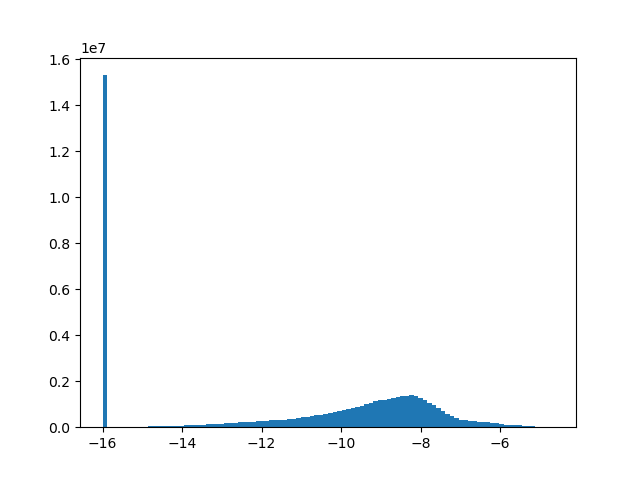

In [202]:
plt.hist(np.log10(final_weights.clip(1e-16)),bins=100) ;

In [ ]:
# How many of the largest concentrations must be retained in order
# for the final answer to be within 1% of exact?

In [204]:
order=np.argsort(-unweighted)
weighted=unweighted*final_weights

running_total=np.cumsum(weighted[order])

total=running_total[-1]

In [207]:
idx99=np.searchsorted(running_total,0.99*total)
print("Summing %d of %d largest concentrations gives 99%% of total concentration"%(idx99,len(final_weights)))
# 16M out of 55M

Summing 16574676 of 55860683 largest concentrations gives 99% of total concentration


In [211]:
# Replicate the opencl test computation
N=50*1024_000
A=np.arange(N)
B=N-A
C=np.zeros_like(A)

# 52ms
%timeit np.add(A,B,out=C)

52.1 ms ± 504 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
